In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading and preprocessing the dataset...
Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Class distribution in training set: Counter({0: 227451, 1: 394})

---- FEATURE SELECTION ----
Top 15 features selected: ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4', 'V18', 'V9', 'V3', 'V7', 'V1', 'V2', 'V21', 'V5']
Reduced training set shape: (227845, 15)

---- MODEL WITH HYPERPARAMETER TUNING ----
Finding optimal parameters with cross-validation...
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

---- MODEL EVALUATION ----

Optimal threshold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



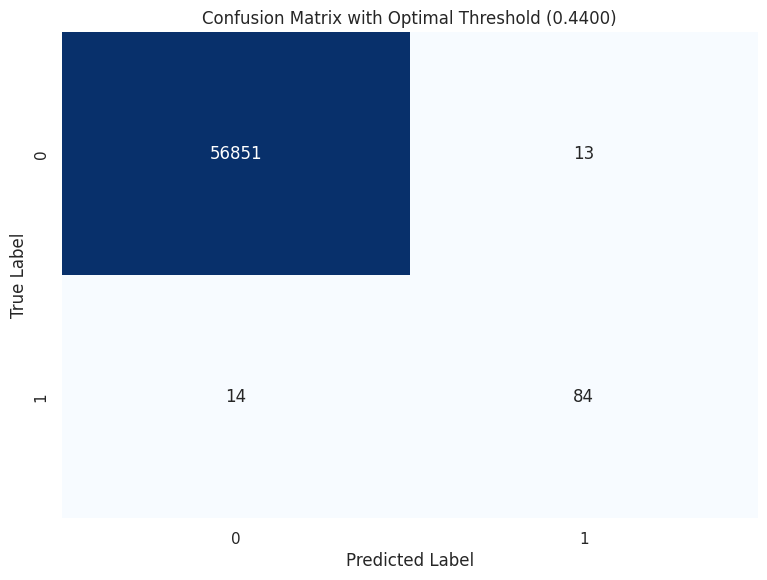


---- SUMMARY OF RESULTS ----
Performance with optimal threshold (0.4400):
- Accuracy: 0.9995
- Precision: 0.8660
- Recall (Sensitivity): 0.8571
- Specificity: 0.9998
- F1 Score: 0.8615
- ROC AUC: 0.9709
- PR AUC: 0.8493


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                            precision_recall_curve, f1_score, precision_score, recall_score)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid', palette='muted')

# 1. DATA LOADING AND PREPROCESSING
print("Loading and preprocessing the dataset...")
df = pd.read_csv('/content/creditcard.csv')

# Split data into features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale the Amount and Time features
amount = X['Amount'].values.reshape(-1, 1)
time = X['Time'].values.reshape(-1, 1)

scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(amount)
X['Time'] = scaler.fit_transform(time)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Class distribution in training set: {Counter(y_train)}")

# 2. FEATURE SELECTION
print("\n---- FEATURE SELECTION ----")

# Train a preliminary Random Forest to determine feature importance
preliminary_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight={0: 1, 1: 5},
    random_state=42
)
preliminary_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = preliminary_rf.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importances)[::-1]

# Select top 15 features
top_15_indices = indices[:15]
top_features = [features[i] for i in top_15_indices]
print(f"Top 15 features selected: {top_features}")

# Keep only selected features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

print(f"Reduced training set shape: {X_train_reduced.shape}")

# 3. MODEL WITH HYPERPARAMETER TUNING
print("\n---- MODEL WITH HYPERPARAMETER TUNING ----")

# 3.1 Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# 3.2 Initialize Random Forest with class weighting
rf = RandomForestClassifier(
    class_weight={0: 1, 1: 5},
    random_state=42
)

# 3.3 Use GridSearchCV to find optimal parameters with cross-validation
print("Finding optimal parameters with cross-validation...")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_reduced, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# 4. MODEL EVALUATION
print("\n---- MODEL EVALUATION ----")

# Get predictions and probabilities
y_prob = best_rf.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve and AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)

# Find optimal threshold based on F1 score
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    f = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f)

# Find optimal threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Apply optimal threshold and evaluate
y_pred_optimal = (y_prob >= best_threshold).astype(int)

# Calculate metrics for optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

# Calculate core metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


print("\nOptimal threshold Classification Report:")
print(classification_report(y_test, y_pred_optimal))

# Create confusion matrix for optimal threshold
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix with Optimal Threshold ({best_threshold:.4f})')
plt.savefig('optimal_threshold_confusion_matrix.png')
plt.show()

# Print summary metrics
print("\n---- SUMMARY OF RESULTS ----")
print(f"Performance with optimal threshold ({best_threshold:.4f}):")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- Precision: {precision:.4f}")
print(f"- Recall (Sensitivity): {recall:.4f}")
print(f"- Specificity: {specificity:.4f}")
print(f"- F1 Score: {f1:.4f}")
print(f"- ROC AUC: {roc_auc:.4f}")
print(f"- PR AUC: {pr_auc:.4f}")